In [93]:
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import pandas as pd
import collections, numpy

from scipy.spatial.distance import cdist
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from knn import KNNClassifier
from metrics import binary_classification_metrics, multiclass_accuracy
from joblib import Memory

In [96]:
plt.rcParams["figure.figsize"] = 12, 5
sns.set_style("whitegrid")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

**Задание 1**. KNN на датасете Fashion-MNIST (10 баллов)
В этом задании вам предстоит поработать с картинками одежды, среди которых можно выделить 10 классов. Данные уже загружены за вас: в переменной X лежат 70000 картинок размером 28 на 28 пикселей, вытянутые в вектор размерностью 784 (28 * 28). Так как данных довольно много, а наш KNN будет весьма медленный, то возьмем случайно 1000 наблюдений (в реальности в зависимости от вашей реализации можно будет взять больше, но если будет не зватать ОЗУ, то берите меньше).

In [97]:
memory = Memory('./tmp')
fetch_openml_cached = memory.cache(fetch_openml)
X, y = fetch_openml_cached(name="Fashion-MNIST", return_X_y=True, as_frame=False)

________________________________________________________________________________
[Memory] Calling sklearn.datasets._openml.fetch_openml...
fetch_openml(name='Fashion-MNIST', return_X_y=True, as_frame=False)
____________________________________________________fetch_openml - 27.9s, 0.5min


In [98]:
idx_to_stay = np.random.choice(np.arange(X.shape[0]), replace=False, size=1000)
X = X[idx_to_stay]
y = y[idx_to_stay]

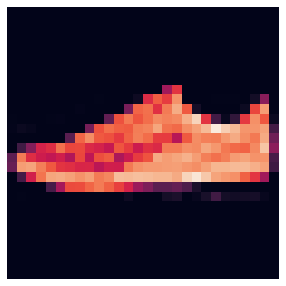

In [99]:
# возьмем случайную картинку и сделаем reshape
# 28, 28, 1 = H, W, C (число каналов, в данном случае 1)
image = X[np.random.choice(np.arange(X.shape[0]))].reshape(28, 28, 1)
plt.imshow(image[:,:,0])
plt.axis("off");

**1.1. Посмотрим на все классы (0.5 баллов)**

Возьмите по одной картинке каждого класса и изобразите их (например, сделайте subplots 5 на 2).

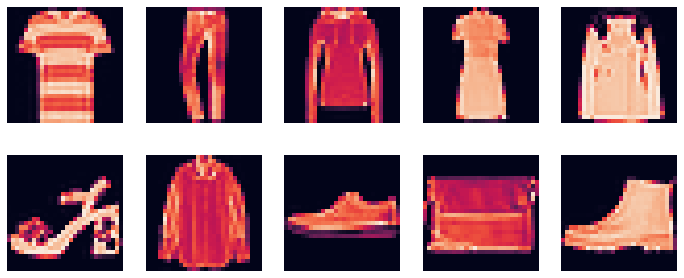

In [100]:
f, axarr = plt.subplots(2,5)
kateg = 0
for i in range(2):
    for j in range(5):
        image = X[np.random.choice(np.where(y==str(kateg))[0])].reshape(28, 28, 1)
        axarr[i][j].imshow(image[:,:,0])
        axarr[i][j].axis("off")
        kateg += 1


**1.2. Сделайте небольшой EDA (1 балл)**

Посмотрите на баланс классов. В дальнейших домашках делайте EDA, когда считаете нужным, он нужен почти всегда, но оцениваться это уже не будет, если не будет указано иное. Делайте EDA, чтобы узнать что-то новое о данных!

In [101]:
collections.Counter(y)

Counter({'5': 98,
         '9': 106,
         '0': 93,
         '3': 121,
         '1': 102,
         '2': 95,
         '8': 109,
         '6': 101,
         '7': 79,
         '4': 96})

Посмотрели на баланс классов, можно сделать вывод, что классы более менее сбалансированы.

**1.3. Разделите данные на train и test (0.5 баллов)**

Разделите данные на тренировочную и тестовую выборки, размеры тестовой выборки выберите сами. Здесь вам может помочь функция train_test_split

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,
                                                    random_state=SEED)
y_train.shape

(900,)

**1.4. KNN для бинарной классификации (6 баллов)**

Давайте возьмем для задачи бинарной классификации только объекты с метками классов 0 и 1.

In [103]:
binary_train_X = X_train[(y_train=='0') | (y_train=='1')]
print(binary_train_X.shape)
binary_train_y = y_train[(y_train=='0') | (y_train=='1')]
collections.Counter(binary_train_y)

(178, 784)


Counter({'1': 93, '0': 85})

In [122]:
binary_test_X = X_test[(y_test=='0') | (y_test=='1')]
print(binary_test_X.shape)
binary_test_y = y_test[(y_test=='0') | (y_test=='1')]
collections.Counter(binary_test_y)

(17, 784)


array(['1', '0', '1', '0', '0', '1', '0', '0', '0', '1', '1', '1', '1',
       '0', '1', '0', '1'], dtype=object)

In [128]:
knn_classifier = KNNClassifier(k=1)
knn_classifier.fit(binary_train_X, binary_train_y)

In [129]:
# TODO: compute_distances_two_loops
dists = knn_classifier.compute_distances_two_loops(binary_test_X)
assert np.isclose(dists[0, 100], np.sum(np.abs(binary_test_X[0] - binary_train_X[100])))
dists.shape

(17, 178)

In [130]:
# TODO: compute_distances_one_loop
dists = knn_classifier.compute_distances_one_loop(binary_test_X)
assert np.isclose(dists[0, 100], np.sum(np.abs(binary_test_X[0] - binary_train_X[100])))
dists

array([[19711, 31093, 29871, ..., 62868, 37755, 19107],
       [65513, 62297, 68405, ..., 24482, 58947, 74821],
       [13594, 33608, 25704, ..., 62289, 33226, 15722],
       ...,
       [12546, 44850, 12088, ..., 61547, 38230, 25714],
       [35969, 27553, 45213, ..., 46516, 42331, 36467],
       [23451, 38505, 31513, ..., 64780, 34695, 24555]])

In [93]:
# TODO: compute_distances_no_loops
#dists = knn_classifier.compute_distances_no_loops(binary_test_X)
#assert np.isclose(dists[0, 100], np.sum(np.abs(binary_test_X[0] - binary_train_X[100])))

Проверим скорость работы реализованных методов

In [94]:
%timeit knn_classifier.compute_distances_two_loops(binary_test_X)
%timeit knn_classifier.compute_distances_one_loop(binary_test_X)
#%timeit knn_classifier.compute_distances_no_loops(binary_test_X)

Реализуем метод для предсказания меток класса

In [131]:
# TODO: predict_labels_binary in knn.py
prediction = knn_classifier.predict(binary_test_X, n_loops=1)
prediction

array([ True, False,  True, False, False,  True, False, False, False,
        True,  True,  True,  True, False,  True, False,  True])

### Метрика

Теперь нужно реализовать несколько метрик для бинарной классификации. Не забудьте подумать о численной нестабильности (деление на 0).

In [96]:
# TODO: binary_classification_metrics in metrics.py

In [132]:
binary_test_y = binary_test_y.astype(np.int)
binary_train_y = binary_train_y.astype(np.int)

In [133]:
prediction = prediction.astype(np.int)
prediction

array([1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1])

In [134]:
binary_classification_metrics(prediction, binary_test_y)

(1.0, 1.0, 1.0, 1.0)

In [135]:
precision, recall, accuracy, f1 = binary_classification_metrics(prediction, binary_test_y)

Все ли хорошо с моделью? Можно проверить свою реализацию с функциями из библиотеки `sklearn`:

In [136]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [137]:
precision_score(binary_test_y, prediction)

1.0

In [138]:
recall_score(binary_test_y, prediction)

1.0

In [139]:
f1_score(binary_test_y, prediction)

1.0

In [140]:
accuracy_score(binary_test_y, prediction)

1.0

### Подбор оптимального k

Чтобы подрбрать оптимальное значение параметра k можно сделать следующее: задать область допустимых значений k, например, `[1, 3, 5, 10]`. Дальше для каждого k обучить модель на тренировочных данных, сделать предсказания на тестовых и посчитать какую-нибудь метрику (метрику выберите сами исходя из задачи, но постарайтесь обосновать выбор). В конце нужно посмотреть на зависимость метрики на train'е и test'е от k и выбрать подходящее значение.

Реализуйте функцию `choose_best_k` прямо в ноутбуке.

In [141]:
def find_best_k(X_train, y_train, X_test, y_test, params, metric):
    """
    Choose the best k for KKNClassifier
    Arguments:
    X_train, np array (num_train_samples, num_features) - train data
    y_train, np array (num_train_samples) - train labels
    X_test, np array (num_test_samples, num_features) - test data
    y_test, np array (num_test_samples) - test labels
    params, list of hyperparameters for KNN, here it is list of k values
    metric, function for metric calculation
    Returns:
    train_metrics the list of metric values on train data set for each k in params
    test_metrics the list of metric values on test data set for each k in params
    """
    train_metrics = []
    test_metrics = []
    for k in params:
        knn_classifier = KNNClassifier(k)
        knn_classifier.fit(X_train, y_train)
        y_test_pred = knn_classifier.predict(X_test, n_loops=1)
        test_metrics += [metric(y_test_pred, y_test)]
        y_train_pred = knn_classifier.predict(X_train, n_loops=1)
        train_metrics += [metric(y_train_pred, y_train)]
    
    
    return train_metrics, test_metrics

In [150]:
params = [1, 2, 4, 5, 8, 10, 30]

def accuracy_score(y_pred, y_true):
    return binary_classification_metrics(y_pred, y_true)[2]
def precision(y_pred, y_true):
    return binary_classification_metrics(y_pred, y_true)[0]
def recall(y_pred, y_true):
    return binary_classification_metrics(y_pred, y_true)[1]

train_metrics, test_metrics = find_best_k(binary_train_X, binary_train_y, binary_test_X, binary_test_y, params, precision)

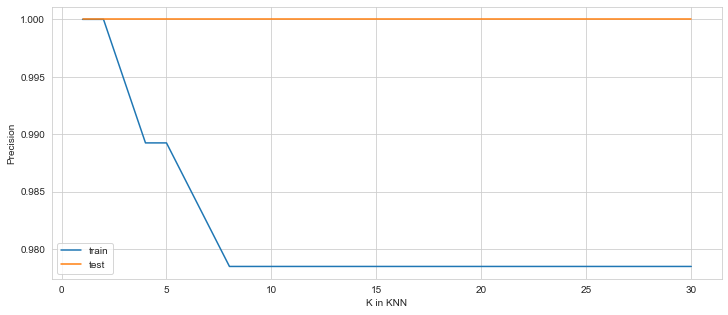

In [152]:
plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("Precision");

## Задание 2. KNN на датасете diabetes (10 баллов)

Теперь попробуем применить KNN к задаче регрессии. Будем работать с данными о диабете. В этом задании будем использовать класс KNeighborsRegressor из библиотеки sklearn. Загрузим необходимые библиотеки:

In [1]:
from sklearn.datasets import load_diabetes
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

In [13]:
X, y = load_diabetes(as_frame=True, return_X_y=True)

In [14]:
X

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641
...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018118,0.044485
439,0.041708,0.050680,-0.015906,0.017282,-0.037344,-0.013840,-0.024993,-0.011080,-0.046879,0.015491
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044528,-0.025930


**2.1. EDA (2 обязательных балла + 2 доп. балла за Pipeline)**

Сделайте EDA, предобработайте данные так, как считаете нужным, нужна ли в данном случае стандартизация и почему? Не забудте, что если вы стандартизуете данные, то нужно считать среднее и сдандартное отклонение на тренировочной части и с помощью них трансформировать и train, и test (если не поняли это предложение, то обязательно разберитесь).

Дополнительно: Попробуйте разобраться с Pipeline, чтобы можно было создать класс, который сразу проводит стандартизацию и обучает модель (или делает предсказание). Пайплайны очень удобны, когда нужно применять различные методы предобработки данных (в том числе и к разным столбцам), а также они позволяют правильно интегрировать предобработку данных в различные классы для поиска наилучших гиперпараметров модели (например, GridSearchCV).

Стандартизация не нужна, так как данные уже стандартизованы. 

In [24]:
print(X.isna().any().any())
print(y.isna().any())

False
False


In [29]:
diab_df = pd.merge(X, y, left_index=True, right_index=True)
diab_df

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0
...,...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207,178.0
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018118,0.044485,104.0
439,0.041708,0.050680,-0.015906,0.017282,-0.037344,-0.013840,-0.024993,-0.011080,-0.046879,0.015491,132.0
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044528,-0.025930,220.0


In [30]:
corr = diab_df.corr()

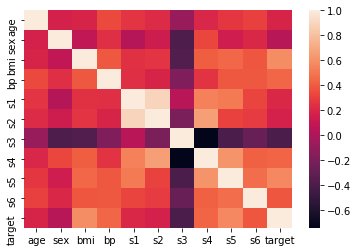

In [31]:
sns.heatmap(corr)

In [32]:
from sklearn.pipeline import Pipeline

**2.2. Регрессионная модель (1 балл)**

Создайте модель `KNeighborsRegressor`, обучите ее на треноровочных данных и сделайте предсказания.

In [33]:
from sklearn.neighbors import KNeighborsRegressor

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,
                                                    random_state=SEED)

In [68]:
y_test = list(y_test)
y_train = list(y_train)

In [37]:
regr = KNeighborsRegressor(n_neighbors=5)
regr.fit(X_train, y_train)

KNeighborsRegressor()

In [43]:
y_pred = regr.predict(X_test)
print(y_pred)

[226.2 143.4 170.  144.2 135.8 190.  125.4 114.4  88.8  67.8 121.  240.4
 225.4 221.4 160.4 189.6 218.2 136.2 236.2  75.4  99.4 150.6 133.  194.4
  73.8 110.4  59.2 115.4 215.  117.2 107.4 125.4 140.  154.6 102.4 105.8
 101.4 156.  183.2 123.6 143.  219.6 124.2 123.6 150. ]


In [59]:
r_squared(y_pred, y_test)

0.14143191475961947

In [60]:
mse(y_pred, y_test)

3352.6240000000007

In [61]:
mae(y_pred, y_test)

43.66222222222223

**2.4. Подбор оптимального числа соседей (2 балла)**

Мы почти дошли до конца. Теперь осталось при помощи реализованных нами метрик выбрать лучшее количество соседей для нашей модели.

!!! Обратите внимание на то, что значат наши метрики, для некоторых хорошо, когда они уменьшаются, для других наоборот.

In [62]:
from metrics import r_squared, mse, mae

In [64]:
def k_neig_regr(k):
    regr = KNeighborsRegressor(n_neighbors = k)
    regr.fit(X_train, y_train)
    return regr


In [65]:
def find_best_k(X_train, y_train, X_test, y_test, params, metric):
    train_metrics = []
    test_metrics = []
    for k in params:
        regressor =  k_neig_regr(k)
        y_test_pred = regressor.predict(X_test)
        test_metrics += [metric(y_test_pred, y_test)]
        y_train_pred = regressor.predict(X_train)
        train_metrics += [metric(y_train_pred, y_train)]
    
    
    return train_metrics, test_metrics

In [66]:
params = [1, 3, 5, 10, 15, 30, 40]

In [72]:
train_r2, test_r2 = find_best_k(X_train, y_train, X_test, y_test, params, r_squared)

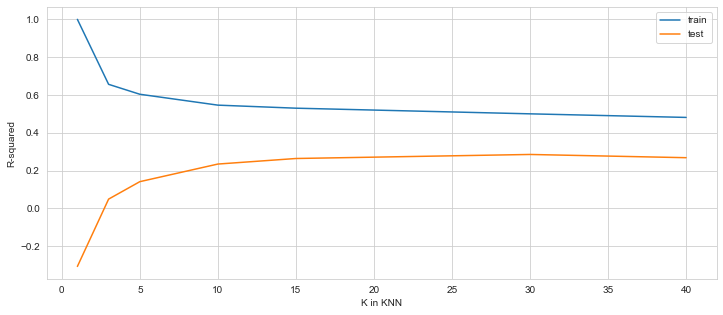

In [83]:
plt.plot(params, train_r2, label="train")
plt.plot(params, test_r2, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("R-squared");

In [79]:
train_mse, test_mse = find_best_k(X_train, y_train, X_test, y_test, params, mse)

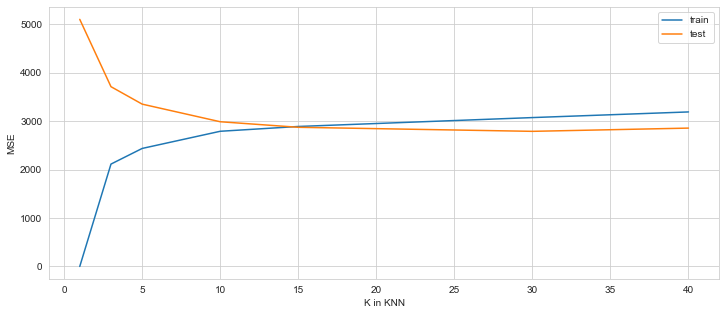

In [81]:
plt.plot(params, train_mse, label="train")
plt.plot(params, test_mse, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("MSE");

In [77]:
train_mae, test_mae = find_best_k(X_train, y_train, X_test, y_test, params, mae)

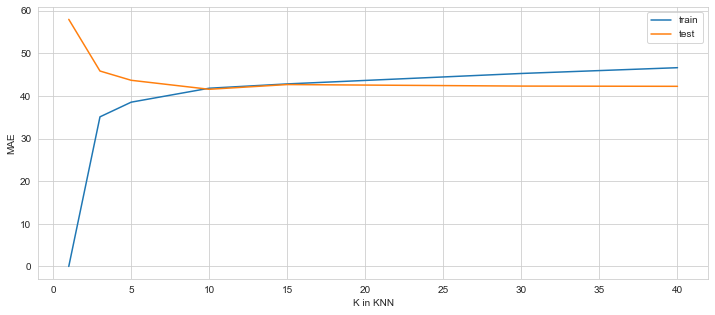

In [82]:
plt.plot(params, train_mae, label="train")
plt.plot(params, test_mae, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("MAE");

Можно сделать вывод по графикам, что к=10  - оптимально